# Helmholtz equation

We present a differentiable solver for the Helmholtz equation, based on `torch-harmonics`. 

In [1]:
import paddle
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import ceil

import sys
sys.path.append("..")
from paddle_harmonics.sht import *
from paddle_harmonics.examples import SphereSolver


cmap = "twilight_shifted"

c:\Users\lixia\AppData\Local\anaconda3\envs\paddle310\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [2]:
device = paddle.set_device('gpu' if paddle.device.cuda.device_count() != 0 else 'cpu')

We define a shallow water solver class in `shallow_water_equations.py`

In [3]:
# initialize parameters:
nlat = 128
nlon = 2 * nlat
lmax = ceil(nlon / 4)
mmax = lmax

# timestepping
dt = 0.001
maxiter = int(10 / dt)

# initialize solver class
solver = SphereSolver(nlat, nlon, dt, lmax=lmax, mmax=mmax, coeff=0.01).to(device)

lons = solver.lons
lats = solver.lats

jj, ii = paddle.triu_indices(lmax, mmax)

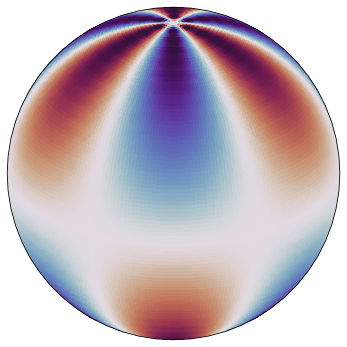

In [4]:
def compute_initial_condition(solver, device=paddle.CPUPlace()):
    """
    Computes the initial condition
    """

    lats, lons = paddle.meshgrid(solver.lats, solver.lons)

    u0 = paddle.zeros((nlat, nlon))
    u0 = paddle.sin(lats) * paddle.cos(3 * lons)
    u0spec = solver.grid2spec(u0)

    return paddle.tril(u0spec)

uspec0 = compute_initial_condition(solver, device=device)

fig = plt.figure(figsize=(8, 6), dpi=72)
solver.plot_specdata(uspec0, fig=fig, vmax=1.0, vmin=-1.0)
plt.show()

preparing the simulation

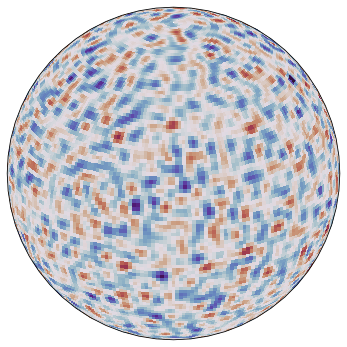

In [5]:
uspec0 = solver.randspec()
fig = plt.figure(figsize=(8, 6), dpi=72)
solver.plot_specdata(uspec0, fig, cmap=cmap)
plt.show()

t=0.00
t=0.02
t=0.04
t=0.06
t=0.08
t=0.10
t=0.12
t=0.14
t=0.16
t=0.18
t=0.20
t=0.22
t=0.24
t=0.26
t=0.28
t=0.30
t=0.32
t=0.34
t=0.36
t=0.38
t=0.40
t=0.42
t=0.44
t=0.46
t=0.48
t=0.50
t=0.52
t=0.54
t=0.56
t=0.58
t=0.60
t=0.62
t=0.64
t=0.66
t=0.68
t=0.70
t=0.72
t=0.74
t=0.76
t=0.78
t=0.80
t=0.82
t=0.84
t=0.86
t=0.88
t=0.90
t=0.92
t=0.94
t=0.96
t=0.98
t=1.00
t=1.02
t=1.04
t=1.06
t=1.08
t=1.10
t=1.12
t=1.14
t=1.16
t=1.18
t=1.20
t=1.22
t=1.24
t=1.26
t=1.28
t=1.30
t=1.32
t=1.34
t=1.36
t=1.38
t=1.40
t=1.42
t=1.44
t=1.46
t=1.48
t=1.50
t=1.52
t=1.54
t=1.56
t=1.58
t=1.60
t=1.62
t=1.64
t=1.66
t=1.68
t=1.70
t=1.72
t=1.74
t=1.76
t=1.78
t=1.80
t=1.82
t=1.84
t=1.86
t=1.88
t=1.90
t=1.92
t=1.94
t=1.96
t=1.98
t=2.00
t=2.02
t=2.04
t=2.06
t=2.08
t=2.10
t=2.12
t=2.14
t=2.16
t=2.18
t=2.20
t=2.22
t=2.24
t=2.26
t=2.28
t=2.30
t=2.32
t=2.34
t=2.36
t=2.38
t=2.40
t=2.42
t=2.44
t=2.46
t=2.48
t=2.50
t=2.52
t=2.54
t=2.56
t=2.58
t=2.60
t=2.62
t=2.64
t=2.66
t=2.68
t=2.70
t=2.72
t=2.74
t=2.76
t=2.78
t=2.80
t=2.82
t=2.84

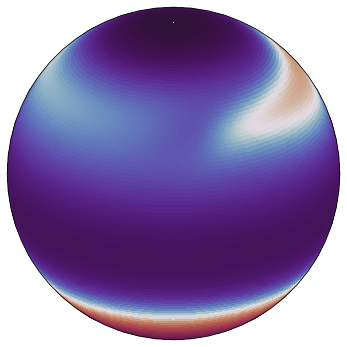

In [6]:
dudtspec = paddle.zeros((3, solver.lmax, solver.mmax), dtype=paddle.float64)
dudtspec = dudtspec.astype(paddle.complex128).to(device)

nnew = 0
nnow = 1
nold = 2

uspec = uspec0.clone().to(device)
# pde = 'allen-cahn'
pde = "ginzburg-landau"

# prepare figure for animation
fig = plt.figure(figsize=(8, 6), dpi=72)
moviewriter = animation.writers["pillow"](fps=20)
moviewriter.setup(fig, pde + ".gif", dpi=72)

with paddle.no_grad():
    for iter in range(maxiter + 1):
        t = iter * dt

        if iter % 20 == 0:
            print(f"t={t:.2f}")
            plt.clf()
            solver.plot_specdata(uspec, fig, cmap=cmap)
            plt.draw()
            moviewriter.grab_frame()

        dudtspec[nnew] = solver.dudtspec(uspec, pde=pde)

        # forward euler, then 2nd-order adams-bashforth time steps to start.
        if iter == 0:
            dudtspec[nnow] = dudtspec[nnew]
            dudtspec[nold] = dudtspec[nnew]
        elif iter == 1:
            dudtspec[nold] = dudtspec[nnew]

        uspec = uspec + solver.dt * (
            (23.0 / 12.0) * dudtspec[nnew]
            - (16.0 / 12.0) * dudtspec[nnow]
            + (5.0 / 12.0) * dudtspec[nold]
        )

        # implicit hyperdiffusion for vort and div.
        # uspec[1:] = swe_solver.hyperdiff * uspec[1:]
        # switch indices, do next time step.
        nsav1 = nnew
        nsav2 = nnow
        nnew = nold
        nnow = nsav1
        nold = nsav2

moviewriter.finish()